# Chapter 11: Dense Vector Representations
## A Language Detector
This program is inspired by Google's CLD3: `https://github.com/google/cld3`

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Collecting the Dataset

Uncomment and run these lines once to download the corpus and move it in your dataset folder

In [1]:
#!wget https://downloads.tatoeba.org/exports/sentences.tar.bz2
#!tar -xvjf sentences.tar.bz2
#!mkdir ../datasets/tatoeba
#!mv sentences.csv ../datasets/tatoeba
#!rm sentences.tar.bz2

## Modules

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import random
from collections import Counter
import pandas as pd
import hashlib
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
PATH = '../datasets/tatoeba/'
TATOEBA_FILE = 'sentences.csv'

In [4]:
SENT_PER_LANG = 20000
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.1
TEST_PERCENT = 0.1
N_MAX = 3
EMBEDDING_DIM = 64

In [5]:
MAX_CHARS = 2053
MAX_BIGRAMS = 4099
MAX_TRIGRAMS = 4099
MODS = [MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS]

In [6]:
random.seed(4321)
torch.manual_seed(4321)

## The Corpus

In [7]:
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [8]:
line_generator = file_reader(PATH + TATOEBA_FILE)

In [9]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [10]:
sum(lang_freqs.values())

12053705

In [11]:
lang_freqs.most_common(3)

[('eng', 1896014), ('rus', 1063819), ('ita', 876185)]

In [12]:
selected_langs = {lang: freq for lang, freq
                  in lang_freqs.items()
                  if freq > SENT_PER_LANG}

To ease training, we select `sent_per_lang` sentences (15,000 or 1000) of each language in `selected_languages`. For this, we first write a generator that will return the sentence if it is less than a random number. We use a uniform random generator between 0 and 1. If we want to select 10% of the sentences of a given language, we will return the sentence when the random number is less than 0.1, for 20%, it will be 0.2, etc.

The percentage is given by `sent_per_lang` divided by the number of sentence in the language.

We first write a generator that will return the sentence if it is less than a random number. We use a uniform random generator between 0 and 1. If we want to select 10% of the sentences of a given language, we will return the sentence when the random number is less than 0.1, for 20%, it will be 0.2, etc.

In [13]:
lang_percentage = dict()
for lang, freq in selected_langs.items():
    lang_percentage[lang] = SENT_PER_LANG/freq

In [14]:
lang_percentage

{'cmn': 0.26934575915102216,
 'deu': 0.030328671816475142,
 'rus': 0.01880019063393303,
 'fra': 0.03311324066041047,
 'eng': 0.010548445317386896,
 'jpn': 0.08306993242260997,
 'spa': 0.04912689230648303,
 'ita': 0.022826229620456866,
 'vie': 0.8047318231199453,
 'nld': 0.10803802938634399,
 'epo': 0.026469766893997847,
 'por': 0.04637057508787224,
 'tur': 0.027257500241910315,
 'heb': 0.09941000164026503,
 'hun': 0.049104698583083924,
 'ell': 0.5115089514066496,
 'ind': 0.8670770831526923,
 'ara': 0.3119589462026797,
 'fin': 0.1340329855177359,
 'bul': 0.8010253123998718,
 'swe': 0.35676061362825545,
 'ukr': 0.10750260693821825,
 'ces': 0.2526847757422615,
 'pol': 0.15649942095214248,
 'lat': 0.39124396017136487,
 'ron': 0.5753077896674721,
 'yid': 0.9783299907058651,
 'srp': 0.3952881650723377,
 'dan': 0.31865908258050124,
 'pes': 0.6892273761113792,
 'tgl': 0.26242930810512916,
 'lit': 0.1870260059661296,
 'mkd': 0.25573158412929786,
 'tok': 0.34740919592141606,
 'ina': 0.5782853838

In [15]:
len(lang_percentage)

42

In [16]:
line_generator = file_reader(PATH + TATOEBA_FILE)
working_corpus = []
for lang_tuple in line_generator:
    lang = lang_tuple[1]
    if (lang in lang_percentage and
            random.random() < lang_percentage[lang]):
        working_corpus += [lang_tuple]

In [17]:
len(working_corpus)

840533

In [18]:
random.shuffle(working_corpus)

In [19]:
dp = pd.DataFrame(working_corpus)

In [20]:
dp

,0,1,2
0,11003835,swc,Awataki kulinda haki yenu. Wanataka wa atcha.
1,10938219,fra,Merci mais je suis conscient de tout ce que vo...
2,10324498,fra,Le pauvre homme couchait dans la soue.
3,186971,jpn,家々はお互いに近付いてたっている。
4,4579970,ind,Kau tinggal di rumah yang mana?
...,...,...,...
840528,11004301,swc,"Hauiwazie kweli, si vile?"
840529,1740977,swe,Visst är det möjligt om man vill.
840530,867500,pol,"Nie umiem rysować, za to moja siostra jest wsp..."
840531,4050922,mkd,Она што не ме убива ме прави посилен.


In [21]:
split_sizes = list(map(lambda x: int(len(working_corpus) * x),
                   (TRAIN_PERCENT, VAL_PERCENT, TEST_PERCENT)))
split_sizes

[672426, 84053, 84053]

In [22]:
offsets = [sum(split_sizes[:i])
           for i in range(len(split_sizes))]
offsets

[0, 672426, 756479]

In [23]:
training_set = working_corpus[:offsets[1]]
val_set = working_corpus[offsets[1]:offsets[2]]
test_set = working_corpus[offsets[2]:]

In [24]:
dp_train = pd.DataFrame(training_set)
dp_val = pd.DataFrame(val_set)
dp_test = pd.DataFrame(test_set)

In [25]:
dp_train

,0,1,2
0,11003835,swc,Awataki kulinda haki yenu. Wanataka wa atcha.
1,10938219,fra,Merci mais je suis conscient de tout ce que vo...
2,10324498,fra,Le pauvre homme couchait dans la soue.
3,186971,jpn,家々はお互いに近付いてたっている。
4,4579970,ind,Kau tinggal di rumah yang mana?
...,...,...,...
672421,7997987,fin,Laitan sen korvani taakse.
672422,783527,epo,Ĉu vi povus vortigi tion per pli simplaj vortoj?
672423,1339384,fra,Combien de temps dois-je patienter ?
672424,7947159,fin,Tom ei pidä Marin asenteesta.


In [26]:
dp_val

,0,1,2
0,10455637,hun,Összemérték az erejüket.
1,11983416,yid,איך האָב תּמיד געוואָלט זען דעם מילכוועג.
2,4672756,lit,Tomas buvo areštuotas praėjusį mėnesį.
3,655581,pes,دارم با تام حرف می زنم.
4,1705682,lat,Didymus lavatur.
...,...,...,...
84048,9431633,kab,Kra n wass ad tendemmeḍ.
84049,10743810,tok,sina wan taso lon ni anu seme?
84050,6733874,rus,Чем оно тебе не нравится?
84051,1924310,fra,Il l'a fait par curiosité.


In [27]:
dp_test

,0,1,2
0,11946256,ara,لقد وافقت على تلك الفكرة.
1,5765789,ukr,Значення за замовчуванням — нуль.
2,8419848,lit,Tomas daug kartų buvo Bostone.
3,4385838,hun,Milyen volt az utazásod?
4,10907050,swc,Mwipwa yake alivutiwa na feu d'artifice.
...,...,...,...
84049,11004301,swc,"Hauiwazie kweli, si vile?"
84050,1740977,swe,Visst är det möjligt om man vill.
84051,867500,pol,"Nie umiem rysować, za to moja siostra jest wsp..."
84052,4050922,mkd,Она што не ме убива ме прави посилен.


In [28]:
dp_train.to_csv(PATH + 'tatoeba.train', sep='\t',
                header=False, index=False)

## Character $N$-grams

In [29]:
def ngrams(sentence: str,
           n: int = 1) -> list[str]:
    ngram_l = []
    for i in range(len(sentence) - n + 1):
        ngram_l += [sentence[i:i+n]]
    return ngram_l

In [30]:
def all_ngrams(sentence: str,
               max_ngram: int = 3,
               lc=True) -> list[list[str]]:
    if lc:
        sentence = sentence.lower()
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i)]
    return all_ngram_list

In [31]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

In [32]:
charsets = [set() for i in range(N_MAX)]
for lang_tuple in training_set:
    ngrams_l = all_ngrams(lang_tuple[2],
                          max_ngram=N_MAX)
    for ngram_l, charset in zip(ngrams_l, charsets):
        charset.update(ngram_l)

In [33]:
list(map(len, charsets))

[5128, 103037, 347640]

## Encoding the $N$-grams

### Hashing

In [34]:
hash('a')

3343378650118523443

In [35]:
hash('ab')

-3359459818933296038

In [36]:
hash('abc')

8018964178423155579

In [37]:
hashlib.md5('a'.encode("utf-8"), usedforsecurity=False)

<md5 _hashlib.HASH object @ 0x344063ef0>

In [38]:
hashlib.md5('a'.encode("utf-8"), usedforsecurity=False).digest()

b'\x0c\xc1u\xb9\xc0\xf1\xb6\xa81\xc3\x99\xe2iw&a'

In [39]:
def reproducible_hash(string: str) -> int:
    """
    reproducible hash on any string

    Arguments:
       string: python string object

    Returns:
       signed int64
   Author: Marcus Klang
    """

    # We are using MD5 for speed not security.
    h = hashlib.md5(string.encode('utf-8'),
                    usedforsecurity=False)
    return int.from_bytes(h.digest()[0:8], 'big', signed=True)

In [40]:
def hash_str_list(text: list[str],
                  char_mod: int) -> list[int]:
    values = map(lambda x: x % char_mod,
                 map(reproducible_hash, text))
    return list(values)

## Building $X$ and $\mathbf{y}$

In [41]:
idx2lang = dict(enumerate(sorted(selected_langs)))
lang2idx = {v: k for k, v in idx2lang.items()}

In [42]:
y_train = torch.LongTensor(
    [lang2idx[tuple_lang[1]]
     for tuple_lang in training_set])
y_val = torch.LongTensor(
    [lang2idx[tuple_lang[1]]
     for tuple_lang in val_set])
y_test = torch.LongTensor(
    [lang2idx[tuple_lang[1]]
     for tuple_lang in test_set])

In [43]:
def hash_all_ngrams(text: str,
                    max_ngram=N_MAX,
                    mod_list=MODS):
    all_ngrams_l = all_ngrams(text, max_ngram)
    x = []
    for ngram_l, mod in zip(all_ngrams_l, mod_list):
        x += [torch.LongTensor(hash_str_list(ngram_l, mod))]
    return x

In [44]:
def build_X(dataset):
    X = []
    for lang_tuple in tqdm(dataset):
        x = hash_all_ngrams(lang_tuple[2])
        X += [x]
    return X

In [45]:
X_train = build_X(training_set)
X_val = build_X(val_set)
X_test = build_X(test_set)

100%|██████████| 84054/84054 [00:07<00:00, 11032.13it/s]


In [46]:
X_train[:1]

[[tensor([1917, 1022, 1917, 1810, 1917,  185,   90, 1446,  185, 1304,   76,   90,
          1195,  584, 1917, 1446,  832, 1917,  185,   90, 1446,  289,  989, 1195,
          1304,  406, 1446, 1022, 1917, 1195, 1917, 1810, 1917,  185, 1917, 1446,
          1022, 1917, 1446, 1917, 1810,  944,  832, 1917,  406]),
  tensor([  74, 1979, 2210, 1288,  272,  242, 1681, 3868, 1182, 1912,  585,  161,
          2258, 3266, 2559, 1242, 2264,  272,  242, 1681, 3725,  545,  309, 3957,
          1777, 2766, 1673, 1979, 3906, 2726, 2210, 1288,  272, 3476, 2559, 1673,
          1979, 2559, 2716, 2210, 1994, 1100, 2264,  699]),
  tensor([2069, 3491, 2929, 2961, 3823,  600, 1410,  193, 1053,  609, 1100, 1573,
          1870, 2844,  872, 3998, 3602, 3823,  600, 2204,  352,  111, 1887, 1750,
          2917, 4024,  943, 3087, 3321, 2117, 2929, 2961, 1775, 3095, 2397,  943,
          2369, 2518, 1646, 1062, 3403, 2865, 1914])]]

## Embedding Bags

In [47]:
embs = nn.EmbeddingBag(3, 5)

In [48]:
embs(torch.LongTensor([[0, 1, 2], [2, 1, 0]]))

tensor([[-0.2384,  0.4318,  0.1966, -0.3318, -0.5874],
        [-0.2384,  0.4318,  0.1966, -0.3318, -0.5874]],
       grad_fn=<EmbeddingBagBackward0>)

In [49]:
embs(torch.LongTensor([0, 1, 2, 2, 1, 0]),
     torch.LongTensor([0, 3]))

tensor([[-0.2384,  0.4318,  0.1966, -0.3318, -0.5874],
        [-0.2384,  0.4318,  0.1966, -0.3318, -0.5874]],
       grad_fn=<EmbeddingBagBackward0>)

In [50]:
# Creates a vector (1D tensor) from one list corresponding to a batch
def bag_generator(X_idx_l: list):
    X_idx = torch.cat(X_idx_l, dim=-1)
    # We shift the offsets
    bag_lengths = [X_idx_l[i].size(dim=0)
                   for i in range(len(X_idx_l))]
    X_offsets = [sum(bag_lengths[:i])
                 for i in range(len(bag_lengths))]
    return X_idx, torch.LongTensor(X_offsets)

In [51]:
bags_idx, bags_offsets = zip(
    *map(bag_generator, zip(*X_train[0:5])))

We obtain three bags and three offsets

In [52]:
bags_idx, bags_offsets

((tensor([1917, 1022, 1917, 1810, 1917,  185,   90, 1446,  185, 1304,   76,   90,
          1195,  584, 1917, 1446,  832, 1917,  185,   90, 1446,  289,  989, 1195,
          1304,  406, 1446, 1022, 1917, 1195, 1917, 1810, 1917,  185, 1917, 1446,
          1022, 1917, 1446, 1917, 1810,  944,  832, 1917,  406, 1079,  989,   46,
           944,   90, 1446, 1079, 1917,   90, 2005, 1446, 1645,  989, 1446, 2005,
          1304,   90, 2005, 1446,  944,  856, 1195, 2005,  944,   90,  989, 1195,
          1810, 1446,  584,  989, 1446, 1810,  856, 1304, 1810, 1446,  944,  989,
          1446, 1431, 1304,  989, 1446,  349,  856, 1304, 2005, 1446, 1917,  349,
           989, 1418, 1446, 2005, 1304,  676,  676,  789,   46,  789,  406,   76,
           989, 1446, 1657, 1917, 1304,  349,   46,  989, 1446,  832,  856, 1079,
          1079,  989, 1446,  944,  856, 1304,  944,  832, 1917,   90, 1810, 1446,
           584, 1917, 1195, 2005, 1446,   76, 1917, 1446, 2005,  856, 1304,  989,
           406, 

## Model

In [53]:
class LangDetector(nn.Module):
    def __init__(self, MODS, EMBEDDING_DIM, n_lang):
        super().__init__()
        (MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS) = MODS
        self.emb_chars = nn.EmbeddingBag(MAX_CHARS,
                                         EMBEDDING_DIM)
        self.emb_bigr = nn.EmbeddingBag(MAX_BIGRAMS,
                                        EMBEDDING_DIM)
        self.emb_trig = nn.EmbeddingBag(MAX_TRIGRAMS,
                                        EMBEDDING_DIM)
        self.fc = nn.Linear(3 * EMBEDDING_DIM, n_lang)

    def forward(self, bags, offsets):
        (bags1, bags2, bags3) = bags
        (offsets1, offsets2, offsets3) = offsets
        x1 = self.emb_chars(bags1, offsets1)
        x2 = self.emb_bigr(bags2, offsets2)
        x3 = self.emb_trig(bags3, offsets3)
        x = torch.hstack((x1, x2, x3))
        x = self.fc(x)
        return x

In [54]:
model = LangDetector(MODS, EMBEDDING_DIM, len(lang2idx))

## Training Loop

In [55]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)

In [56]:
def predict_batched(model, X, batch_size=1024):
    y_pred = []
    for i in range(0, len(X), batch_size):
        X_bags_idx, X_bags_offsets = zip(
            *map(bag_generator, zip(*X[i:i+batch_size])))
        Y_pred_batch = model(X_bags_idx, X_bags_offsets)
        y_pred_batch = torch.argmax(Y_pred_batch, dim=-1)
        y_pred += [y_pred_batch]
    return torch.cat(y_pred, dim=-1)

In [57]:
def eval_batched(model, X, y, batch_size=1024):
    acc = []
    loss = []
    for i in range(0, len(y), batch_size):
        X_bags_idx, X_bags_offsets = zip(
            *map(bag_generator, zip(*X[i:i+batch_size])))
        Y_pred_batch = model(X_bags_idx, X_bags_offsets)
        y_batch = y[i:i + batch_size]
        loss_batch = loss_fn(Y_pred_batch, y_batch)
        loss += [loss_batch.item()]
        y_pred_batch = torch.argmax(Y_pred_batch, dim=-1)
        acc_batch = torch.sum(y_batch == y_pred_batch)/y_batch.size(dim=0)
        acc += [acc_batch.item()]
    return sum(loss)/len(loss), sum(acc)/len(acc)

In [58]:
BATCH_SIZE = 512

In [59]:
loss_train_history = []
acc_train_history = []
loss_val_history = []
acc_val_history = []

for epoch in tqdm(range(2)):
    loss_train = 0
    acc_train = 0
    cnt = 0
    model.train()
    n_indices = list(range(0, len(X_train), BATCH_SIZE))
    random.shuffle(n_indices)  # Check if there is a PyTorch equivalent
    for i in n_indices:
        X_train_bags_idx, X_train_bags_offsets = zip(
            *map(bag_generator,
                 zip(*X_train[i:i + BATCH_SIZE])))
        y_batch = y_train[i:i + BATCH_SIZE]
        y_pred_batch = model(X_train_bags_idx,
                             X_train_bags_offsets)
        loss_batch = loss_fn(y_pred_batch, y_batch)
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        loss_train += loss_batch.item()
        acc_train += torch.sum(
            y_batch == torch.argmax(y_pred_batch,
                                    dim=-1))/BATCH_SIZE
    acc_train /= len(n_indices)
    acc_train_history += [acc_train.item()]
    loss_train /= len(n_indices)
    loss_train_history += [loss_train]

    model.eval()
    with torch.no_grad():
        loss_val, acc_val = eval_batched(model, X_val, y_val)
        loss_val_history += [loss_val]
        acc_val_history += [acc_val]

100%|██████████| 2/2 [00:23<00:00, 11.82s/it]


In [60]:
acc_train_history

[0.9474871158599854, 0.9760779142379761]

In [61]:
acc_val_history

[0.9702207266566265, 0.9727974397590361]

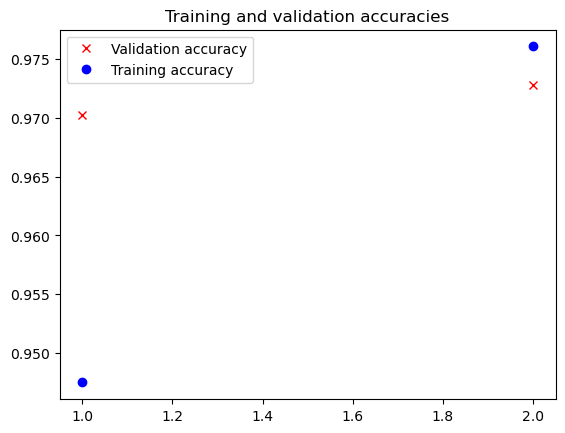

In [62]:
epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Training accuracy')
plt.title('Training and validation accuracies')
plt.legend()
plt.show()

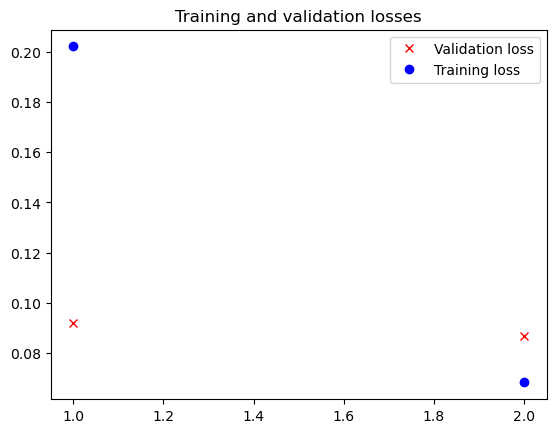

In [63]:
epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history, 'bo', label='Training loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

In [64]:
def predict_batched(model, X, batch_size=1024):
    y_pred = []
    for i in range(0, len(X), batch_size):
        X_bags_idx, X_bags_offsets = zip(
            *map(bag_generator, zip(*X[i:i+batch_size])))
        Y_pred_batch = model(X_bags_idx, X_bags_offsets)
        y_pred_batch = torch.argmax(Y_pred_batch, dim=-1)
        y_pred += [y_pred_batch]
    return torch.cat(y_pred, dim=-1)

In [65]:
y_val_pred = predict_batched(model, X_val, batch_size=1024)

In [66]:
print(classification_report(y_val, y_val_pred,
                            target_names=sorted(selected_langs), digits=4))

              precision    recall  f1-score   support

         ara     0.9969    0.9949    0.9959      1949
         ber     0.8082    0.7725    0.7899      2013
         bul     0.9263    0.9521    0.9390      2006
         ces     0.9948    0.9787    0.9867      1968
         cmn     1.0000    0.9954    0.9977      1972
         dan     0.9588    0.9726    0.9657      2010
         deu     0.9903    0.9917    0.9910      2053
         ell     1.0000    1.0000    1.0000      1952
         eng     0.9908    0.9845    0.9876      2070
         epo     0.9848    0.9892    0.9870      2031
         fin     0.9890    0.9935    0.9913      1999
         fra     0.9868    0.9798    0.9833      1982
         hau     0.9882    0.9916    0.9899      2027
         heb     0.9980    0.9965    0.9973      2010
         hun     0.9915    0.9895    0.9905      2007
         ina     0.9493    0.9474    0.9484      2017
         ind     0.9881    0.9814    0.9847      2038
         ita     0.9718    

In [67]:
y_test_pred = predict_batched(model, X_test, batch_size=1024)

In [68]:
print(classification_report(y_test, y_test_pred,
                            target_names=sorted(selected_langs), digits=4))

              precision    recall  f1-score   support

         ara     0.9946    0.9975    0.9961      2040
         ber     0.8057    0.7775    0.7913      2000
         bul     0.9365    0.9543    0.9453      1993
         ces     0.9954    0.9828    0.9891      1980
         cmn     0.9995    0.9985    0.9990      2038
         dan     0.9743    0.9734    0.9738      2064
         deu     0.9890    0.9910    0.9900      1993
         ell     1.0000    1.0000    1.0000      1971
         eng     0.9908    0.9837    0.9873      1968
         epo     0.9836    0.9918    0.9877      1941
         fin     0.9925    0.9875    0.9900      2005
         fra     0.9861    0.9917    0.9889      1936
         hau     0.9955    0.9875    0.9915      1999
         heb     0.9975    0.9929    0.9952      1971
         hun     0.9935    0.9916    0.9926      2017
         ina     0.9519    0.9421    0.9470      1952
         ind     0.9850    0.9841    0.9845      2007
         ita     0.9719    

In [69]:
test_sents = ['Groovin\' on a Sunday afternoon',
              'La Folle Complainte',
              'Vent\'anni o poco più',
              'Tous les garçons et les filles',
              'Mambo italiano']

In [70]:
X_sent = []
for sent in test_sents:
    x = hash_all_ngrams(sent)
    X_sent += [x]

In [71]:
list(map(idx2lang.get, predict_batched(model, X_sent, batch_size=1024).tolist()))

['eng', 'fra', 'ita', 'fra', 'tgl']